In [2]:
# set up libraries we'll need
import pandas as pd
import regex as re
import string
import csv

In [3]:
# import and preview dataset
# dataset from https://www.ire.org/events-and-training/conferences/nicar-2019
dataset = pd.read_csv('data/car19guide.csv')
dataset.head()

,event_id,name,clean_description,location_room,start_date_clean,start_time,end_time,pre_reg_flag,paid_flag,laptop_flag,speakers_cleaned,session_type,keywords,skill_level,session_title
0,4178,(Generally) painless collaboration with the gr...,Traditional reporters and editors often view t...,Salon A&B,2019-03-09,2019-03-09 15:30:00,2019-03-09 16:30:00,False,False,False,"Ryann Grochowski Jones, ProPublica (moderator)...",Panel,NaN,General interest,(Generally) painless collaboration with the gr...
1,4162,25th CAR: What a ride it's been!,Buckle up for a fast-paced ride through 25 yea...,Salon C&D,2019-03-08,2019-03-08 15:30:00,2019-03-08 16:30:00,False,False,False,"Doug Haddix, IRE/NICAR; Shawn McIntosh, Atlant...",Panel,NaN,General interest,25th CAR: What a ride it's been!
2,4189,50 databases to request right now,Get your FOI templates ready to roll. In this ...,Salon D,2019-03-09,2019-03-09 14:15:00,2019-03-09 15:15:00,False,False,False,"Mark Walker, The New York Times; Kate Martin, ...",Panel,NaN,General interest,50 databases to request right now
3,4198,A conversation with James B. Steele: Insights ...,This special session features the wit and wisd...,Salon A&B,2019-03-09,2019-03-09 10:15:00,2019-03-09 11:15:00,False,False,False,"Sarah Cohen, ASU Cronkite School of Journalism...",Panel,NaN,NaN,A conversation with James B. Steele: Insights ...
4,4301,Adding a text editor to your CAR toolkit,A good text editor is an essential tool for da...,Salon A&B,2019-03-10,2019-03-10 10:15:00,2019-03-10 11:15:00,False,False,False,"Agustin Armendariz, The New York Times",Demo,NaN,Intermediate,Adding a text editor to your CAR toolkit


In [4]:
# create new dataset with only the fields we want
subset = dataset.loc[:, ['name','clean_description']] # 'session_title' seems to be same as name
# add a column with the year
subset['conference_year'] = '2019'
subset.head()

,name,clean_description,conference_year
0,(Generally) painless collaboration with the gr...,Traditional reporters and editors often view t...,2019
1,25th CAR: What a ride it's been!,Buckle up for a fast-paced ride through 25 yea...,2019
2,50 databases to request right now,Get your FOI templates ready to roll. In this ...,2019
3,A conversation with James B. Steele: Insights ...,This special session features the wit and wisd...,2019
4,Adding a text editor to your CAR toolkit,A good text editor is an essential tool for da...,2019


In [5]:
# through manual analysis of the schedule, I found some that are not classes or are duplicate sessions
# these rows have names containing strings we can filter out using pipe
# thanks to https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe

filter_out = ['registration', 'sales', 'repeat']
filtered_subset = subset[~subset['name'].str.contains('|'.join(filter_out))]
# reset indices
filtered_subset = filtered_subset.reset_index(drop=True)

In [6]:
# preliminary text exploration
# fetch word count for each description
pd.options.mode.chained_assignment = None # get rid of warning...

filtered_subset['word_count'] = filtered_subset['clean_description'].apply(lambda x: len(str(x).split(" ")))
filtered_subset[['clean_description','word_count']].head()

,clean_description,word_count
0,Traditional reporters and editors often view t...,68
1,Buckle up for a fast-paced ride through 25 yea...,99
2,Get your FOI templates ready to roll. In this ...,56
3,This special session features the wit and wisd...,194
4,A good text editor is an essential tool for da...,49


In [7]:
# descriptive statistics of word counts
filtered_subset.word_count.describe()

count    225.000000
mean      81.973333
std       37.831383
min        3.000000
25%       58.000000
50%       75.000000
75%       98.000000
max      210.000000
Name: word_count, dtype: float64

In [8]:
# copy descriptions to new column for pre-processing
filtered_subset['preproc_desc'] = filtered_subset['clean_description']

# # make every word in descriptions lowercase
# filtered_subset['preproc_desc'] = filtered_subset['preproc_desc'].apply(lambda x: x.lower())
# # remove punctuation before looking for common/uncommon words because adjacent punctuation changes words
# filtered_subset['preproc_desc'] = filtered_subset['preproc_desc'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
# filtered_subset['preproc_desc'].head()

In [18]:
# # identify common words
# # could be used for custom stop word list
# freq = pd.Series(' '.join(filtered_subset['preproc_desc']).split()).value_counts()[:50]
# freq
# # only domain-specific words that we might want to keep out of stoplist are 'data', 'learn', 'stories'

In [20]:
# # identify uncommon words
# # inform cleaning needed?
# unfreq =  pd.Series(' '.join(filtered_subset 
#          ['preproc_desc']).split()).value_counts()[-20:]
# unfreq

In [10]:
# https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
# libraries for text-preprocessing

# download these the first time you run this
#nltk.download('stopwords')
#nltk.download('wordnet') 

from nltk.corpus import stopwords
# stemming normalizes text by removing suffixes
from nltk.stem.porter import PorterStemmer
# lemmatisation works based on the root of the word.
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [11]:
# creating a list of stop words (plus adding custom stopwords if we want)
stop_words = set(stopwords.words("english"))# creating a list of custom stopwords
new_words = []
stop_words = stop_words.union(new_words)

In [12]:
# with the stopwords, clean and normalize the corpus
# TODO: replace hyphens/apostrophes/slashes with ' ' or ''?
corpus = []
for i in range(0, filtered_subset['preproc_desc'].count()): # don't hard code number of rows!
    #Remove punctuations
#     text = re.sub('[^a-zA-Z]', ' ', filtered_subset['preproc_desc'][i])
    text = filtered_subset['preproc_desc'][i].translate(str.maketrans('','',string.punctuation))
    
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
#     text=re.sub("(\\d|\\W)+"," ",text)

    # remove special characters
    text=re.sub("(\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Stemming
    ps=PorterStemmer()    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [13]:
# view an example corpus item
print(corpus[37])

session introduce bridge gap visualization library like d3 latest component framework javascript show mixing two become powerful way build reusable chart component shortcut dev time extend impact work student get reusable chart template take home session good people background d3


In [14]:
# testing if " r " shows up
sub = ' d3 '
print('\n'.join(s for s in corpus if sub in s))

session introduce bridge gap visualization library like d3 latest component framework javascript show mixing two become powerful way build reusable chart component shortcut dev time extend impact work student get reusable chart template take home session good people background d3
skill level intermediate bring data life elegant intelligent visualization d3 javascript library well start javascript basic learn make d3 library powerful use realworld datasets build first d3 chart build d3js basic exploring complex chart form covering function fetching manipulating data introducing transition interaction write working code together break favorite example d3 chart work preregistration required seating limited laptop provided training workshop prerequisite knowledge htmlcss programming concept previous javascript d3 experience required
cover basic getting started d3 even never used take several real datasets use create basic chart session good people basic grasp javascript syntax interested b

In [15]:
# get word counts for every single word in the corpus
# https://www.geeksforgeeks.org/python-count-occurrences-of-each-word-in-given-text-file-using-dictionary/

# create an empty dictionary
counts = dict()

for desc in corpus: 
    # remove leading spaces
    desc = desc.strip() 
  
    # split the line into words 
    words = desc.split(" ") 
    
    for word in words:
        # Check if the word is already in dictionary 
        if word in counts: 
            # Increment count of word by 1 
            counts[word] = counts[word] + 1
        else: 
            # Add the word to dictionary with count 1 
            counts[word] = 1

In [16]:
# sort dictionary by word count values
import collections

sorted_counts_list = sorted(counts.items(), key=lambda x: x[1])
sorted_counts = collections.OrderedDict(sorted_counts_list)

In [17]:
# print dictionary of word counts
# https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

print("There are " + str(len(sorted_counts.keys()))+ " unique words in this corpus.")
for key in list(sorted_counts.keys()): 
    print(key, ":", sorted_counts[key]) 

There are 2734 unique words in this corpus.
onestop : 1
desk : 1
unapproachable : 1
shoot : 1
fullstack : 1
magically : 1
bouncing : 1
head : 1
revamp : 1
reputation : 1
perception : 1
buckle : 1
told : 1
drove : 1
mainstream : 1
pivotal : 1
bizarre : 1
twist : 1
befuddled : 1
bureaucrat : 1
hit : 1
featuring : 1
crina : 1
boros : 1
steve : 1
doig : 1
jaimi : 1
dowdell : 1
reuters : 1
mark : 1
horvit : 1
missouri : 1
brant : 1
houston : 1
illinois : 1
clarence : 1
jennifer : 1
lafleur : 1
quickpaced : 1
lightninground : 1
geek : 1
overlooked : 1
underappreciated : 1
wit : 1
accomplished : 1
1972 : 1
l : 1
1000 : 1
inquirer : 1
largest : 1
40 : 1
magazine : 1
slew : 1
inc : 1
vanity : 1
fair : 1
arizona : 1
ran : 1
shared : 1
medal : 1
allowing : 1
inspect : 1
tidy : 1
seamlessly : 1
cm : 1
clustering : 1
equivalent : 1
thorough : 1
covered : 1
replace : 1
concatenate : 1
cellcross : 1
foreach : 1
least : 1
else : 1
questioning : 1
subqueries : 1
neat : 1
unnatural : 1
occur : 1
longter

builtin : 1
testing : 1
sleep : 1
night : 1
mapped : 1
publicly : 1
familiarising : 1
composer : 1
dissolving : 1
polygon : 1
street : 1
sqllike : 1
charting : 1
pipeline : 1
operation : 1
usable : 1
significance : 1
crosstabulations : 1
per : 1
correlated : 1
clustered : 1
gee : 1
modeling : 1
regular : 1
mustknow : 1
patternmatching : 1
puzzle : 1
batch : 1
searchreplace : 1
action : 1
zip : 1
conquer : 1
fear : 1
sail : 1
alerting : 1
horizon : 1
caching : 1
surveillance : 1
breach : 1
hazard : 1
inherent : 1
mandate : 1
ethic : 1
dilemma : 1
technologist : 1
dataladen : 1
illuminate : 1
organizing : 1
element : 1
starchy : 1
datadump : 1
wellcrafted : 1
layoff : 1
climatechange : 1
shooting : 1
angry : 1
vitriolic : 1
psychic : 1
toll : 1
mounting : 1
thrive : 1
atmosphere : 1
burnout : 1
secondary : 1
train : 1
professional : 1
constant : 1
growing : 1
resilience : 1
cultivating : 1
empathy : 1
selfadvocacy : 1
succeed : 1
rest : 1
trusted : 1
reduce : 1
risk : 1
encourage : 1
rma

another : 6
creative : 6
fun : 6
ever : 6
easy : 6
guide : 6
others : 6
custom : 6
friday : 6
8 : 6
9 : 6
cleaning : 6
interview : 6
column : 6
row : 6
lot : 6
mapping : 6
system : 6
ideal : 6
complex : 6
publish : 6
html : 6
presentation : 6
browser : 6
1 : 6
answer : 6
detail : 6
human : 6
possible : 6
structure : 6
sort : 6
geographic : 6
visualizing : 6
expected : 7
favorite : 7
government : 7
participate : 7
import : 7
openrefine : 7
dive : 7
advanced : 7
quickly : 7
device : 7
end : 7
thing : 7
sure : 7
interesting : 7
digital : 7
job : 7
report : 7
filter : 7
little : 7
lead : 7
big : 7
making : 7
done : 7
important : 7
compelling : 7
turn : 7
science : 7
college : 7
financial : 7
trend : 7
campaign : 7
building : 7
large : 7
every : 7
sorting : 7
filtering : 7
great : 7
creating : 7
network : 7
think : 7
already : 7
qgis : 7
pattern : 7
graphic : 7
panda : 7
scrape : 7
api : 7
workflow : 7
interested : 7
election : 7
learned : 7
managing : 7
visualize : 8
car : 8
hear : 8
speci

In [18]:
# # write dictionary to a csv file

# with open('data/car19_keywords_dups.csv', 'w') as f:
#     for key in sorted_counts.keys():
#         f.write("%s,%s\n"%(key,sorted_counts[key]))

In [19]:
# take 2
# get word counts for every word BUT only counting each word ONCE per description
# https://www.geeksforgeeks.org/python-ways-to-remove-duplicates-from-list/

# create an empty dictionary
counts_no_dups = dict()

for desc in corpus: 
    # remove leading spaces
    desc = desc.strip() 
  
    # split the line into words 
    words = desc.split(" ") 
    
    # remove duplicates within a description
    words_no_dups = [i for n, i in enumerate(words) if i not in words[:n]] 
    
    for word in words_no_dups:
        # Check if the word is already in dictionary 
        if word in counts_no_dups: 
            # Increment count of word by 1 
            counts_no_dups[word] = counts_no_dups[word] + 1
        else: 
            # Add the word to dictionary with count 1 
            counts_no_dups[word] = 1
            
sorted_counts_list_no_dups = sorted(counts_no_dups.items(), key=lambda x: x[1])
sorted_counts_no_dups = collections.OrderedDict(sorted_counts_list_no_dups)

# print("Counting each word once per description, there are " + str(len(sorted_counts_no_dups.keys())) + " unique words in this corpus.")
# for key in list(sorted_counts_no_dups.keys()): 
#     print(key, ":", sorted_counts_no_dups[key]) 

# # write to csv file
# with open('data/car19_keywords_nodups.csv', 'w') as f:
#     for key in sorted_counts_no_dups.keys():
#         f.write("%s,%s\n"%(key,sorted_counts_no_dups[key]))

In [30]:
# # write both counts to a new csv file
# with open('data/car19_keywords_manual_both.csv', 'w', newline='') as csv_writer:
#     keywords_writer = csv.writer(csv_writer, delimiter=',')
#     with open('data/car19_keywords_manual.csv') as csv_file:
#         csv_reader = csv.reader(csv_file, delimiter=',')
#         for row in csv_reader:
#             # print("%s appears %s time(s)"%(row[0],row[1]))
#             keyword = row[0]
#             nodups_value = sorted_counts_no_dups[keyword]
#             new_row = row + [nodups_value]
#             keywords_writer.writerow(new_row)

In [20]:
both_keyword_counts = pd.read_csv('data/car19_keywords_manual_both.csv', header=None)
both_keyword_counts.head()

,0,1,2
0,csvkit,1,1
1,pivottables,1,1
2,pdfs,1,1
3,tidyr,1,1
4,readr,1,1


In [21]:
both_keyword_counts.tail()

,0,1,2
77,python,31,18
78,spreadsheet,32,25
79,r,35,18
80,excel,39,23
81,database,61,37


In [22]:
# graph the data
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
import matplotlib.pyplot as plt
import numpy as np

labels = both_keyword_counts[0].values[::-1][:10]
all_freq = both_keyword_counts[1].values[::-1][:10]
once_freq = both_keyword_counts[2].values[::-1][:10]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, all_freq, width, label='Every occurrence')
rects2 = ax.bar(x + width/2, once_freq, width, label='Unique occurrence per description')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Occurrence')
ax.set_title('Mentions of technology names in CAR19 talk descriptions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize='20')


autolabel(rects1)
autolabel(rects2)

# increase font size
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

fig.tight_layout()

plt.show()

<Figure size 2000x1000 with 1 Axes>

In [23]:
# get counts sorted by unique frequencies
once_freq_sorted = both_keyword_counts.sort_values(by=[2])
once_freq_sorted.tail()

,0,1,2
76,sql,29,19
80,excel,39,23
75,code,27,23
78,spreadsheet,32,25
81,database,61,37


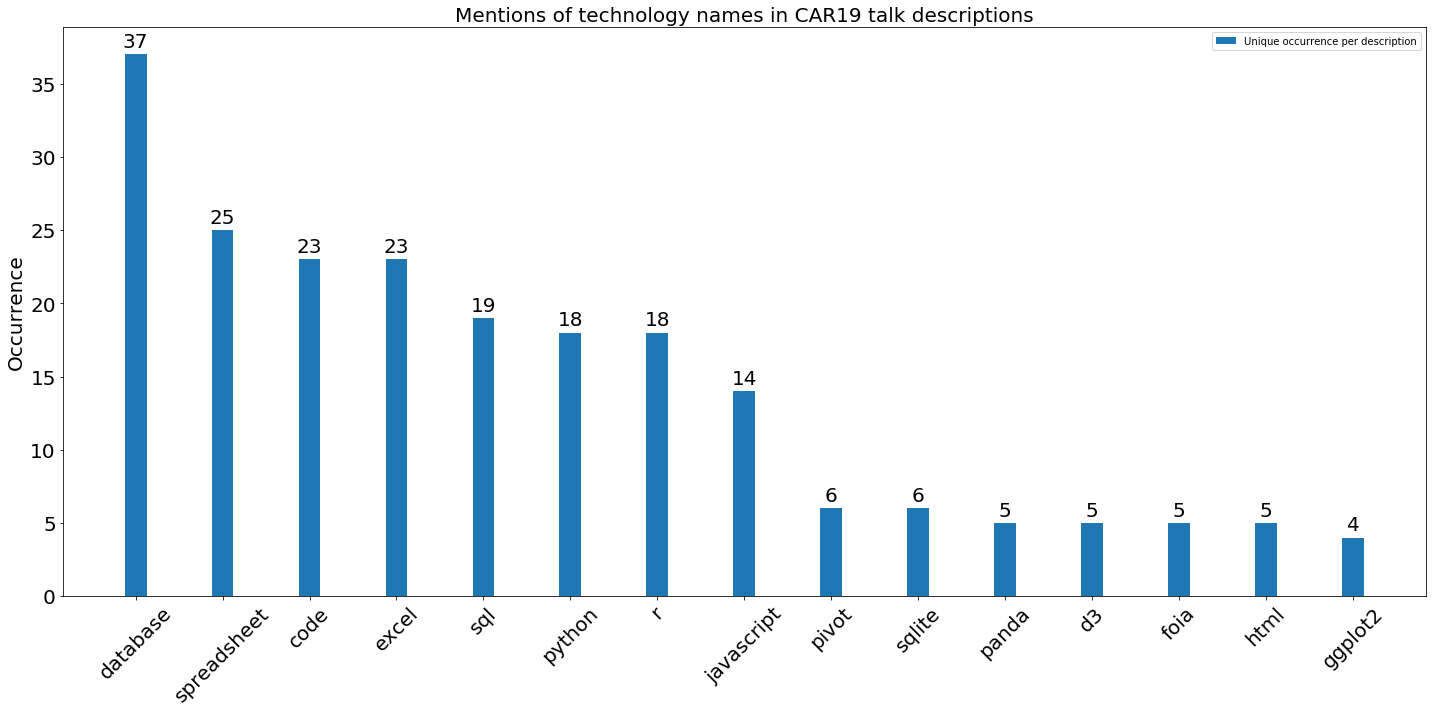

In [24]:
# graph the data
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
import matplotlib.pyplot as plt
import numpy as np

labels = once_freq_sorted[0].values[::-1][:15]
once_freq = once_freq_sorted[2].values[::-1][:15]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
# rects = ax.bar(width, once_freq, width, label='Unique occurrence per description')
rects = ax.bar(x, once_freq, width, align='center', label='Unique occurrence per description')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Occurrence')
ax.set_title('Mentions of technology names in CAR19 talk descriptions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=45)
ax.legend()

# attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize='20')


autolabel(rects)

# increase font size
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

fig.tight_layout()

plt.show()

In [40]:
# WIP write to new csv file with density scores
with open('data/car19_keywords_manual_density.csv', 'w', newline='') as csv_writer:
    keywords_writer = csv.writer(csv_writer, delimiter=',')
    keywords_writer.writerow(["keyword", "count_dups", "count_nodups", "total_words", "density"])
    with open('data/car19_keywords_manual_both.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            print("%s appears %s time(s) total and in %s unique description(s)"%(row[0],row[1],row[2]))
#             keyword = row[0]
#             nodups_value = sorted_counts_no_dups[keyword]
#             new_row = row + [nodups_value]
#             keywords_writer.writerow(new_row)


csvkit appears 1 time(s) total and in 1 unique description(s)
pivottables appears 1 time(s) total and in 1 unique description(s)
pdfs appears 1 time(s) total and in 1 unique description(s)
tidyr appears 1 time(s) total and in 1 unique description(s)
readr appears 1 time(s) total and in 1 unique description(s)
tibble appears 1 time(s) total and in 1 unique description(s)
nodejs appears 1 time(s) total and in 1 unique description(s)
altair appears 1 time(s) total and in 1 unique description(s)
django appears 1 time(s) total and in 1 unique description(s)
scraper appears 1 time(s) total and in 1 unique description(s)
blockchain appears 1 time(s) total and in 1 unique description(s)
documentcloud appears 1 time(s) total and in 1 unique description(s)
topojson appears 1 time(s) total and in 1 unique description(s)
leaflet appears 1 time(s) total and in 1 unique description(s)
pdfplumber appears 1 time(s) total and in 1 unique description(s)
tabula appears 1 time(s) total and in 1 unique des

In [25]:
# see if certain keywords appear together

# convert keywords list into array
keywords_arr = []
with open('data/car19_keywords_manual_both.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        keywords_arr.append(row[0])

# get which keywords are in each description
clustered_keywords = []
for desc in corpus: 
    # remove leading spaces
    desc = desc.strip() 
  
    # split the line into words 
    words = desc.split(" ") 
    
    # remove duplicates within a description
    words_no_dups = [i for n, i in enumerate(words) if i not in words[:n]]
    
    # look for defined keywords in description
    keywords = []
    for k in keywords_arr:
        if k in words_no_dups:
            keywords.append(k)

    if len(keywords) != 0:
        clustered_keywords.append(keywords) 

In [28]:
clustered_keywords

[['database'],
 ['gui', 'excel', 'database'],
 ['grel', 'openrefine', 'excel'],
 ['sqlite', 'sql'],
 ['database'],
 ['foia'],
 ['tableau'],
 ['foia'],
 ['database'],
 ['spreadsheet'],
 ['algorithm'],
 ['database'],
 ['spreadsheet'],
 ['database'],
 ['sql'],
 ['csvkit', 'csv', 'excel', 'database'],
 ['d3', 'javascript'],
 ['flourish', 'spreadsheet'],
 ['pivottables', 'excel'],
 ['spreadsheet', 'excel'],
 ['excel'],
 ['pivot', 'spreadsheet', 'excel'],
 ['pdfs', 'spreadsheet', 'database'],
 ['sql', 'excel', 'database'],
 ['pivot', 'spreadsheet', 'excel'],
 ['spreadsheet', 'excel'],
 ['pdf', 'pdf', 'spreadsheet', 'excel'],
 ['tidyr',
  'readr',
  'tibble',
  'tidyr',
  'readr',
  'tibble',
  'purr',
  'dplyr',
  'rstudio',
  'tidyverse',
  'ggplot2',
  'r'],
 ['code'],
 ['csv'],
 ['qgis', 'spreadsheet', 'r'],
 ['r'],
 ['excel'],
 ['dnsdb', 'database'],
 ['tableau'],
 ['nodejs', 'html', 'javascript', 'code'],
 ['d3js', 'javascript', 'code'],
 ['jupyter', 'panda', 'code', 'python'],
 ['table

In [29]:
from itertools import combinations
# create lists of nodes and edges to graph
edges = []
nodes = []
for ck in clustered_keywords:
    if len(ck) == 1:
        nodes.append(ck[0])
    else:
#         bigrams = [x for x in list(itertools.product(ck,ck)) if x[0] != x[1]]
        bigrams = [x for x in combinations(ck, r=2)]
        edges += bigrams
        
# print("edges")
# print(edges)
# print("nodes")
# print(nodes)

Text(0.5, 1.0, 'Network of technology keywords in CAR19 conference talks')

<Figure size 648x864 with 0 Axes>

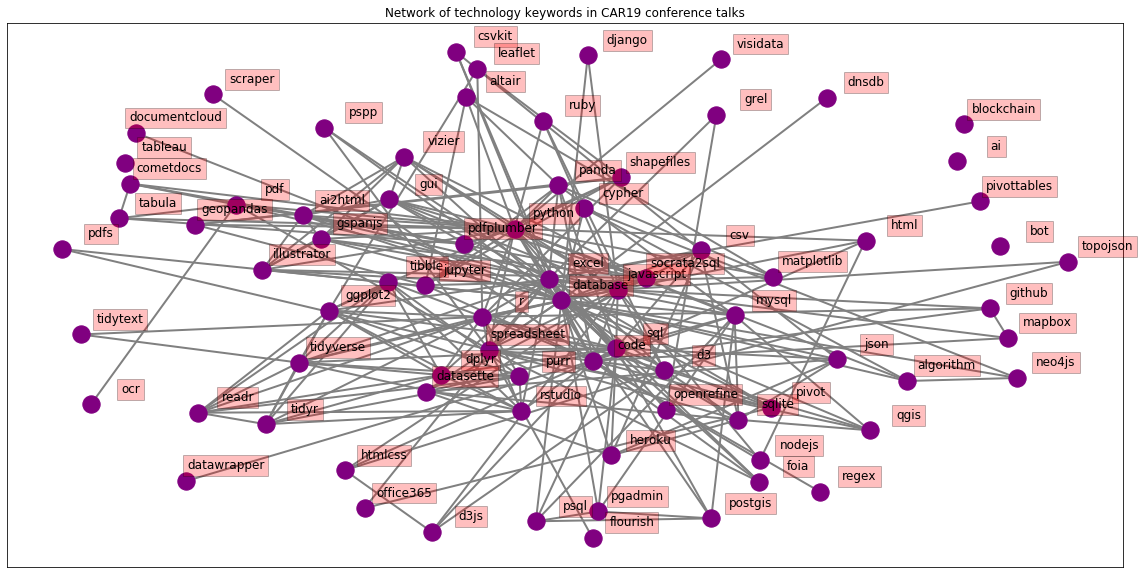

In [30]:
import networkx as nx
G = nx.Graph() 
  
plt.figure(figsize =(9, 12)) 
# G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4),  
#                          (4, 5), (4, 6), (5, 7), (5, 8), (7, 8)]) 
# edges = [('gui', 'excel'),('database','excel')]
# nodes = ['database','r']
G.add_edges_from(edges)
G.add_nodes_from(nodes)

# plot network
# https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/calculate-tweet-word-bigrams-networks-in-python/
# nx.draw_networkx(G) 
fig, ax = plt.subplots(figsize=(20, 10))
pos = nx.spring_layout(G, k=1)
nx.draw_networkx(G, pos,
                 font_size=14,
                 width=2,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 
for key, value in pos.items():
    x, y = value[0]+.075, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

ax.set_title('Network of technology keywords in CAR19 conference talks')

# use plotly instead for interactivity? maybe https://plot.ly/python/network-graphs/

In [55]:
# trying with plotly
import plotly.graph_objects as go

G = nx.Graph() 
G.add_edges_from(edges)
G.add_nodes_from(nodes)

nodelist = []
for n in G.nodes():
    nodelist.append(n)

# pos=nx.fruchterman_reingold_layout(G)   
pos=nx.spring_layout(G)

# edge_x = []
# edge_y = []
# for edge in G.edges():
#     x0, y0 = G.nodes[edge[0]]['pos']
#     x1, y1 = G.nodes[edge[1]]['pos']
#     edge_x.append(x0)
#     edge_x.append(x1)
#     edge_x.append(None)
#     edge_y.append(y0)
#     edge_y.append(y1)
#     edge_y.append(None)

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines')

Xe=[]
Ye=[]
for e in G.edges():
    Xe.extend([pos[e[0]][0], pos[e[1]][0], None])
    Ye.extend([pos[e[0]][1], pos[e[1]][1], None])

edge_trace=dict(type='scatter',
             mode='lines',
             x=Xe,
             y=Ye,
             line=dict(width=1, color='rgb(25,25,25)'),
             hoverinfo='none' 
            )

# node_x = []
# node_y = []
# for node in G.nodes():
#     x, y = G.nodes[node]['pos']
#     node_x.append(x)
#     node_y.append(y)

# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers+text',
#     text=nodelist,
#     hoverinfo='text',
#     marker=dict(
#         showscale=True,
#         # colorscale options
#         #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
#         #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
#         #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#         colorscale='YlGnBu',
#         reversescale=True,
#         color=[],
#         size=10,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
#         line_width=2)
# )

Xn=[pos[nodelist[k]][0] for k in range(len(pos))]
Yn=[pos[nodelist[k]][1] for k in range(len(pos))]

node_trace=dict(type='scatter',
                 x=Xn, 
                 y=Yn,
                 mode='markers+text',
                 text=nodelist,
                 hoverinfo='text',
                marker=dict(
                    showscale=True,
                    # colorscale options
                    #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                    #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                    #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                    colorscale='YlGnBu',
                    reversescale=True,
                    color=[],
                    size=10,
                    colorbar=dict(
                        thickness=15,
                        title='Node Connections',
                        xanchor='left',
                        titleside='right'
                    ),
                    line_width=2))


node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
#     node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace['marker']['size'] = node_adjacencies # can size points by the number of connections using 'size' instead of 'color'
# node_trace.text = node_text

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network of technology keywords in CAR19 conference talks',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

fig.show()

In [42]:
Xn=[pos[nodelist[k]][0] for k in range(len(pos))]

In [47]:
node_trace['marker']

{'showscale': True,
 'colorscale': 'YlGnBu',
 'reversescale': True,
 'color': [],
 'size': 10,
 'colorbar': {'thickness': 15,
  'title': 'Node Connections',
  'xanchor': 'left',
  'titleside': 'right'},
 'line_width': 2}